# Examples of machine learning method


1. Linear regression for Bikes Traffic Prediction

2. Principal Component Analysis (PCA) and Support Vector Machine(SVM) for Face Recognition

3. Random Forest for Classifying Digits

4. K-means for color compression



## Example 1: Linear regression for Bikes Traffic Prediction

There are two raw data in this example.

"fremont_hourly.csv": the hourly number of bikes passing the fremont bridge in Seattle

"2346240.csv": the daily weather forecast in Seattle

Our aims is to use the data in "2346240.csv" to predict the daily number of bikes that pass the fremont bridge in Seattle using linear regression

In statistics, linear regression is a linear approach for modelling the relationship between a scalar response and one or more explanatory variables. Y = AX + B is a simple example of linear regression.

We need to make our dataset(feature extraction, feature selection ,etc) first(step 1 to step 9) and then use a linear regression model for training(step 10 to the end)

In [1]:
# step 1, load the data set and output the first two rows
import os
import pandas as pd
#Load in the data sets 'fremont_hourly.csv' as counts and '2346240.csv' as weather
#For counts, use 'Date' as the rownames
#For weather, use 'DATE' as the rownames
#Use parse_dates=True to try parsing the index as datetime type
counts = pd.read_csv('fremont_hourly.csv',index_col='Date',parse_dates=True)
weather = pd.read_csv('2346240.csv',index_col='DATE',parse_dates=True)

In [2]:
weather.head(2)

,STATION,NAME,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,...,WT03,WT04,WT05,WT08,WT09,WT13,WT14,WT16,WT18,WT22
DATE,,,,,,,,,,,,,,,,,,,,,
2012-10-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",16.33,NaN,0.0,0.0,0.0,NaN,66,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",14.54,NaN,0.0,0.0,0.0,NaN,66,47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
counts.head(2)

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0


In [4]:
# step 2, since the records in 'fremont_hourly.csv' are in 1-hour interval
# we need to summarize them into daily traffic counts
# and create a new dataframe "daily" with column 'Fremont Bridge Total' and print the first five rows

# Hint: resample('d').sum() method to summarize the daily bicycle traffic

daily = counts.resample('d').sum() # resample the data by day, 'd' means the resample frequency day
daily = daily[['Fremont Bridge Total']]
daily.head(5)

,Fremont Bridge Total
Date,
2012-10-03,7042.0
2012-10-04,6950.0
2012-10-05,6296.0
2012-10-06,4012.0
2012-10-07,4284.0


In [5]:
# step 3, create the one-hot encoding for day-of-week in the daily
# since in linear regression, we use the one-hot encoding to denote the multi-category variables (day-of-week in this context).
# print first five rows of the daily
days=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]]=(daily.index.dayofweek==i).astype('int')
daily.head()

,Fremont Bridge Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,7042.0,0,0,1,0,0,0,0
2012-10-04,6950.0,0,0,0,1,0,0,0
2012-10-05,6296.0,0,0,0,0,1,0,0
2012-10-06,4012.0,0,0,0,0,0,1,0
2012-10-07,4284.0,0,0,0,0,0,0,1


In [6]:
# step 4, create a vector for denoting holidays
# expected output: a new column 'holiday' with 1 as holiday and 0 as non-holiday

# Hint: use function USFederalHolidayCalendar() to get the holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays=cal.holidays('2012', '2021')

# print the first five elements of the holidays
print(holidays[:5])

# convert holidays to binary coding, and add a new column "hoilday" in "daily"
daily=daily.join(pd.Series(1,index=holidays,name='holiday'))
daily['holiday']=daily['holiday'].fillna(0).astype('int')

daily.head()

DatetimeIndex(['2012-01-02', '2012-01-16', '2012-02-20', '2012-05-28',
               '2012-07-04'],
              dtype='datetime64[ns]', freq=None)


,Fremont Bridge Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,7042.0,0,0,1,0,0,0,0,0
2012-10-04,6950.0,0,0,0,1,0,0,0,0
2012-10-05,6296.0,0,0,0,0,1,0,0,0
2012-10-06,4012.0,0,0,0,0,0,1,0,0
2012-10-07,4284.0,0,0,0,0,0,0,1,0


In [7]:
# step 5, using the given function to creare a column 'daylight_hrs' to compute the hours of daylight in "daily"
# Sunrise equation for one specific date
import numpy as np
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
          * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
daily['daylight_hrs']=list(map(hours_of_daylight,daily.index))
daily['daylight_hrs']

Date
2012-10-03    11.277359
2012-10-04    11.219142
2012-10-05    11.161038
2012-10-06    11.103056
2012-10-07    11.045208
                ...    
2020-09-26    11.687302
2020-09-27    11.628541
2020-09-28    11.569831
2020-09-29    11.511182
2020-09-30    11.452601
Freq: D, Name: daylight_hrs, Length: 2920, dtype: float64

<AxesSubplot:xlabel='Date'>

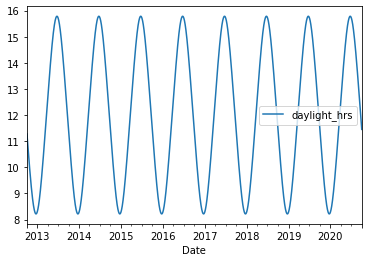

In [8]:
# step 6, plot the hours of daylight of the dataset
daily[['daylight_hrs']].plot()

In [9]:
# step 7, print the first five rows of daily to check what features we got from "fremont_hourly.csv"
daily.head()

,Fremont Bridge Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs
Date,,,,,,,,,,
2012-10-03,7042.0,0,0,1,0,0,0,0,0,11.277359
2012-10-04,6950.0,0,0,0,1,0,0,0,0,11.219142
2012-10-05,6296.0,0,0,0,0,1,0,0,0,11.161038
2012-10-06,4012.0,0,0,0,0,0,1,0,0,11.103056
2012-10-07,4284.0,0,0,0,0,0,0,1,0,11.045208


In [10]:
# step 8, Use the information from 'weather' dataframe to create temperature, dry day and precipitation(PRCP)
# step 8-1,check the shape and the timeindex of `weather` and `daily` dataframes to see if they are aligned
print(weather.shape)
print(daily.shape)

(2920, 26)
(2920, 10)


In [11]:
# step 8-2, choose the columns 'Temp (C)' to compute the average temperature
weather['Temp (C)']=(weather['TMAX']+weather['TMIN'])/2
print(weather['Temp (C)'])

DATE
2012-10-03    56.0
2012-10-04    56.5
2012-10-05    59.5
2012-10-06    60.5
2012-10-07    60.5
              ... 
2020-09-26    59.0
2020-09-27    61.5
2020-09-28    64.0
2020-09-29    67.0
2020-09-30    65.5
Name: Temp (C), Length: 2920, dtype: float64


In [12]:
# step 8-2, create the 'dry day' column, according to the column "PRCP". (If there was no precipitation,then it was a dry day.)
weather['dry day']=(weather['PRCP']==0).astype('int')
weather['dry day']

DATE
2012-10-03    1
2012-10-04    1
2012-10-05    1
2012-10-06    1
2012-10-07    1
             ..
2020-09-26    1
2020-09-27    1
2020-09-28    1
2020-09-29    1
2020-09-30    1
Name: dry day, Length: 2920, dtype: int32

In [13]:
# step 8-3, adding three new column 'Temp (C)','dry day','PRCP' and 'PRCP' in the weather dataframe to the "daily" dataframe
daily=daily.join(weather[['Temp (C)','dry day','PRCP']])
daily.head()

,Fremont Bridge Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,PRCP
Date,,,,,,,,,,,,,
2012-10-03,7042.0,0,0,1,0,0,0,0,0,11.277359,56.0,1,0.0
2012-10-04,6950.0,0,0,0,1,0,0,0,0,11.219142,56.5,1,0.0
2012-10-05,6296.0,0,0,0,0,1,0,0,0,11.161038,59.5,1,0.0
2012-10-06,4012.0,0,0,0,0,0,1,0,0,11.103056,60.5,1,0.0
2012-10-07,4284.0,0,0,0,0,0,0,1,0,11.045208,60.5,1,0.0


In [14]:
# step 9, create a column that measures how many years have passed
# Expected output: a new column 'annual' storing the values of pasting years (float-type)
daily['annual']=(daily.index-daily.index[0]).days/365
daily.head()

,Fremont Bridge Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,PRCP,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0,0,1,0,0,0,0,0,11.277359,56.0,1,0.0,0.000000
2012-10-04,6950.0,0,0,0,1,0,0,0,0,11.219142,56.5,1,0.0,0.002740
2012-10-05,6296.0,0,0,0,0,1,0,0,0,11.161038,59.5,1,0.0,0.005479
2012-10-06,4012.0,0,0,0,0,0,1,0,0,11.103056,60.5,1,0.0,0.008219
2012-10-07,4284.0,0,0,0,0,0,0,1,0,11.045208,60.5,1,0.0,0.010959


### Model fitting and predicting
Use linear regression to predict the daily bicycle traffic. Compare the predicted daily bicycle traffic and the true data by ploting them on the same graph. Print the coefficients of the fitted model.

In [ ]:
# step 10, get the training data and the label, then use linear regression to predict the daily bicycle traffic
# Hint LinearRegression from the sklearn package
from sklearn.linear_model import LinearRegression

# split the training data and the label
y=daily.iloc[:,0]
x=daily.iloc[:,1:]

# train a linear regression model
model=LinearRegression(fit_intercept=False)
model.fit(x,y)

In [17]:
x.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,PRCP,annual
Date,,,,,,,,,,,,,
2012-10-03,0,0,1,0,0,0,0,0,11.277359,56.0,1,0.0,0.000000
2012-10-04,0,0,0,1,0,0,0,0,11.219142,56.5,1,0.0,0.002740
2012-10-05,0,0,0,0,1,0,0,0,11.161038,59.5,1,0.0,0.005479
2012-10-06,0,0,0,0,0,1,0,0,11.103056,60.5,1,0.0,0.008219
2012-10-07,0,0,0,0,0,0,1,0,11.045208,60.5,1,0.0,0.010959


In [18]:
y.head()

Date
2012-10-03    7042.0
2012-10-04    6950.0
2012-10-05    6296.0
2012-10-06    4012.0
2012-10-07    4284.0
Freq: D, Name: Fremont Bridge Total, dtype: float64

In [19]:
# step 11, print the prediction
daily['predicted']=model.predict(x)
daily['predicted'][:5]

Date
2012-10-03    7359.472071
2012-10-04    7149.960643
2012-10-05    6771.272603
2012-10-06    4248.522652
2012-10-07    4085.006460
Freq: D, Name: predicted, dtype: float64

<AxesSubplot:xlabel='Date'>

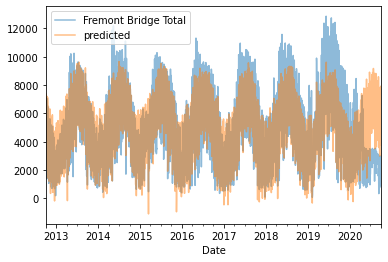

In [20]:
# step 12, plot the prediction and the real data to see the difference
daily[['Fremont Bridge Total', 'predicted']].plot(alpha=0.5)

In [21]:
# step 13, print the parameters
params = pd.Series(model.coef_, index=x.columns)
params.astype(int)

Mon              -43
Tue              150
Wed              114
Thu             -127
Fri             -743
Sat            -3339
Sun            -3494
holiday        -2422
daylight_hrs     142
Temp (C)          81
dry day         1059
PRCP           -1344
annual           -51
dtype: int32

---
## Example 2: PCA and SVM for Face Recognition

Principal component analysis(PCA) is a statistical technique for reducing the dimensionality of a dataset. 

Support Vector Machines(SVMs) are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis.

Aims: Use PCA to extract features, and adjust parameters in the SVM and determine the best model.

### Load in the dataset

In [22]:
# load the data and print
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)#The extracted dataset will only retain pictures of people that have at least min_faces_per_person different pictures.
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


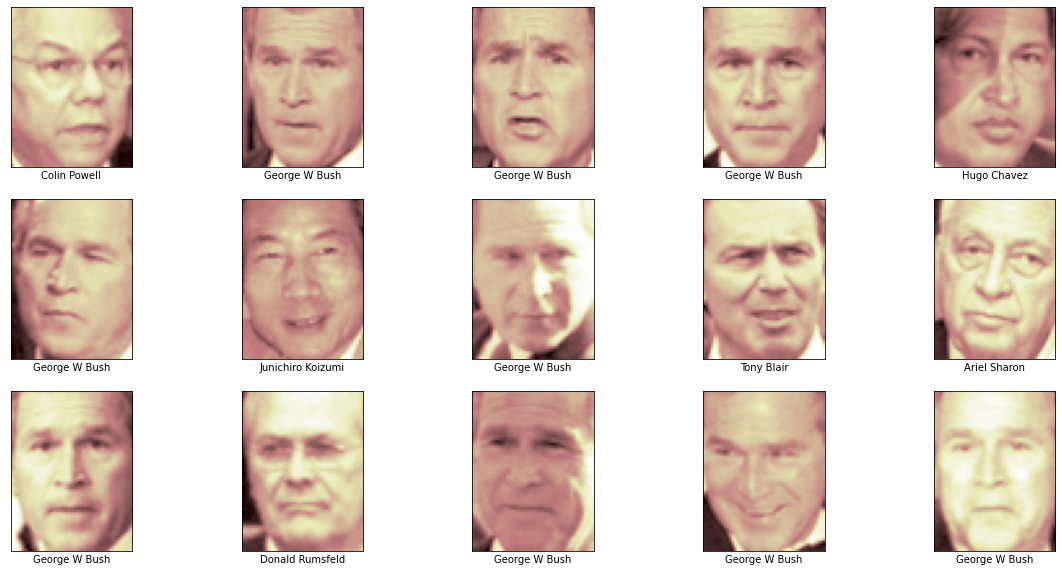

In [23]:
# visualization of the images
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 5,figsize=(20,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='pink')
    axi.set(xticks=[], yticks=[],
        xlabel=faces.target_names[faces.target[i]])

### Model preparation
Hint: 
- For PCA: keep 150 components; use `whiten=True` to keep the outputs with unit component-wise variances
- For SVM: use `'rbf'` kernel and set `class_weight='balanced'`
- Make a pipeline

In [24]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
pca=PCA(n_components=150,whiten=True)
svc=SVC(kernel='rbf',class_weight='balanced')
model=make_pipeline(pca,svc)

### Data set preparation
Hint: split the data into a training and testing set

In [25]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(faces.data,faces.target,random_state=0)

### Parameter tuning and find the best model
Hint: adjust  C (which controls the margin hardness) and  gamma (whichcontrols the size of the radial basis function kernel); use the best model to predict the labels for the test data.

In [26]:
from  sklearn.model_selection import GridSearchCV
import time
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid=GridSearchCV(model,param_grid)
%time grid.fit(Xtrain,ytrain)

Wall time: 27.9 s


GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [1, 5, 10, 50],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]})

In [27]:
model1=grid.best_estimator_
yfit=model1.predict(Xtest)

In [28]:
yfit

array([3, 7, 2, 4, 3, 3, 4, 7, 2, 3, 2, 1, 3, 4, 3, 3, 6, 7, 4, 3, 3, 1,
       3, 6, 3, 3, 3, 1, 3, 1, 3, 3, 3, 7, 7, 3, 7, 3, 4, 3, 4, 3, 3, 3,
       1, 0, 3, 3, 7, 2, 7, 3, 1, 3, 3, 3, 3, 3, 3, 1, 7, 6, 1, 1, 0, 3,
       1, 4, 5, 3, 3, 1, 6, 5, 1, 2, 4, 2, 0, 2, 1, 7, 3, 2, 1, 3, 1, 3,
       3, 3, 3, 2, 6, 3, 3, 1, 7, 3, 3, 7, 1, 3, 3, 1, 3, 1, 7, 3, 7, 6,
       4, 1, 3, 3, 3, 1, 3, 3, 2, 3, 7, 3, 3, 4, 1, 3, 2, 7, 1, 3, 3, 3,
       1, 3, 7, 3, 3, 3, 3, 3, 3, 7, 4, 3, 3, 1, 3, 5, 6, 1, 3, 1, 1, 3,
       3, 7, 3, 3, 3, 7, 1, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 7, 1, 0, 3, 3,
       3, 1, 2, 3, 6, 1, 2, 3, 3, 0, 3, 1, 3, 2, 1, 3, 0, 3, 3, 1, 3, 3,
       1, 1, 1, 5, 3, 2, 0, 3, 3, 2, 1, 7, 3, 3, 3, 3, 7, 2, 2, 3, 4, 1,
       2, 5, 4, 3, 3, 1, 6, 2, 3, 3, 1, 3, 3, 7, 7, 1, 1, 2, 1, 3, 2, 3,
       0, 1, 5, 4, 3, 3, 3, 3, 3, 3, 1, 5, 1, 0, 3, 1, 1, 3, 3, 3, 4, 3,
       2, 6, 6, 3, 3, 4, 1, 2, 2, 0, 3, 3, 3, 3, 3, 3, 6, 3, 2, 3, 3, 3,
       4, 3, 3, 3, 3, 1, 3, 3, 4, 1, 1, 3, 0, 3, 2,

In [29]:
ytest

array([7, 7, 2, 4, 3, 7, 4, 7, 7, 3, 2, 2, 3, 4, 3, 1, 6, 7, 4, 6, 4, 1,
       3, 6, 2, 1, 3, 1, 3, 1, 4, 3, 6, 7, 7, 0, 7, 2, 4, 3, 4, 3, 3, 3,
       1, 0, 3, 3, 2, 2, 7, 3, 1, 3, 5, 3, 3, 3, 7, 1, 7, 6, 1, 1, 0, 3,
       1, 4, 5, 3, 3, 1, 6, 5, 1, 2, 4, 2, 0, 2, 1, 7, 3, 2, 2, 3, 1, 3,
       0, 3, 5, 2, 6, 3, 3, 1, 7, 3, 3, 7, 1, 3, 3, 1, 3, 4, 7, 7, 7, 6,
       4, 1, 3, 3, 3, 1, 3, 3, 2, 3, 7, 2, 3, 4, 0, 3, 2, 4, 1, 6, 3, 3,
       1, 3, 7, 3, 3, 3, 3, 3, 3, 7, 4, 3, 3, 1, 3, 5, 6, 3, 3, 0, 1, 3,
       3, 7, 3, 3, 5, 7, 1, 3, 3, 3, 3, 3, 4, 3, 7, 1, 5, 7, 1, 0, 3, 1,
       3, 1, 2, 3, 6, 1, 2, 3, 3, 0, 3, 3, 3, 2, 1, 3, 0, 3, 3, 5, 3, 5,
       1, 1, 5, 5, 3, 2, 1, 3, 1, 2, 1, 7, 3, 3, 3, 3, 7, 2, 2, 3, 4, 1,
       2, 5, 2, 3, 3, 1, 6, 2, 3, 3, 7, 3, 3, 7, 7, 1, 1, 2, 0, 3, 2, 3,
       0, 1, 5, 4, 3, 3, 4, 4, 7, 3, 1, 5, 1, 0, 3, 1, 1, 3, 5, 4, 4, 3,
       3, 6, 6, 4, 1, 5, 2, 2, 2, 0, 3, 3, 2, 3, 2, 3, 6, 7, 1, 3, 3, 4,
       4, 3, 3, 3, 3, 1, 1, 3, 4, 1, 1, 3, 0, 6, 1,

### Visualize the result

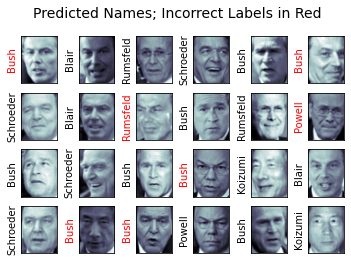

In [30]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [31]:
# print the index
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,target_names=faces.target_names))#Optional display names matching the labels (same order).

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.69      0.79        16
     Colin Powell       0.81      0.84      0.82        61
  Donald Rumsfeld       0.85      0.66      0.74        35
    George W Bush       0.74      0.98      0.84       125
Gerhard Schroeder       0.90      0.66      0.76        29
      Hugo Chavez       1.00      0.47      0.64        19
Junichiro Koizumi       1.00      0.76      0.87        17
       Tony Blair       0.93      0.74      0.83        35

         accuracy                           0.81       337
        macro avg       0.89      0.72      0.79       337
     weighted avg       0.84      0.81      0.81       337



### Draw the confusion matrix

Text(32.99999999999999, 0.5, 'predicted label')

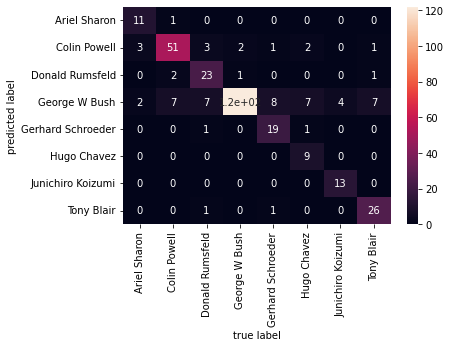

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt 
mat=confusion_matrix(ytest,yfit)
sns.heatmap(mat.T,annot=True,xticklabels=faces.target_names,yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

## Example 3: Random Forest for Classifying Digits

Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time.

Aims: use random forest to classify the digital numbers

In [33]:
# step 1, load the data set
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

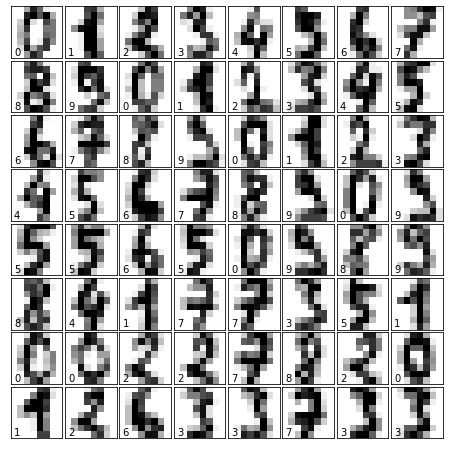

In [34]:
# step 2, visiualization of data 
import matplotlib.pyplot as plt 
# set up the figure
fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [35]:
# step 3, using train_test_split() to split the original data into traning and testing set
from sklearn.ensemble import RandomForestClassifier
import sklearn
Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(digits.data, digits.target, random_state=0)

In [36]:
# step 4: using 1000 trees to build the forest and print the prediction
model=RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain,ytrain)
ypred=model.predict(Xtest)
ypred

array([2, 8, 2, 6, 6, 7, 1, 9, 8, 5, 2, 8, 6, 6, 6, 6, 1, 0, 5, 8, 8, 7,
       8, 4, 7, 5, 4, 9, 2, 9, 4, 7, 6, 8, 9, 4, 3, 1, 0, 1, 8, 6, 7, 7,
       1, 0, 7, 6, 2, 1, 9, 6, 7, 9, 0, 0, 5, 1, 6, 3, 0, 2, 3, 4, 1, 9,
       2, 6, 9, 1, 8, 3, 5, 1, 2, 8, 2, 2, 9, 7, 2, 3, 6, 0, 5, 3, 7, 5,
       1, 2, 9, 9, 3, 1, 7, 7, 4, 8, 5, 8, 5, 5, 2, 5, 9, 0, 7, 1, 4, 7,
       3, 4, 8, 9, 7, 9, 8, 0, 6, 5, 2, 5, 3, 4, 1, 7, 0, 6, 1, 5, 5, 9,
       9, 5, 9, 9, 5, 7, 5, 6, 2, 8, 6, 9, 6, 1, 5, 1, 5, 9, 9, 1, 5, 3,
       6, 1, 8, 9, 7, 7, 6, 7, 6, 5, 6, 0, 8, 8, 9, 8, 6, 1, 0, 4, 1, 6,
       3, 8, 6, 7, 4, 9, 6, 3, 0, 3, 3, 3, 0, 7, 7, 5, 7, 8, 0, 7, 8, 9,
       6, 4, 5, 0, 1, 4, 6, 4, 3, 3, 0, 9, 5, 9, 2, 1, 4, 2, 1, 6, 8, 9,
       2, 4, 9, 3, 7, 6, 2, 3, 3, 1, 6, 9, 3, 6, 3, 2, 2, 0, 7, 6, 1, 1,
       9, 7, 2, 7, 8, 5, 5, 7, 5, 2, 3, 7, 2, 7, 5, 5, 7, 0, 9, 1, 6, 5,
       9, 7, 4, 3, 8, 0, 3, 6, 4, 6, 3, 3, 6, 8, 8, 8, 4, 6, 7, 5, 2, 4,
       5, 3, 2, 4, 6, 9, 4, 5, 4, 3, 4, 6, 2, 9, 0,

In [37]:
# step 5, using metrics.classification_report() to compute and print the precision, recall, F1-score, and the support of the model
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



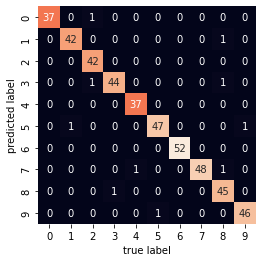

In [38]:
# step 6, using confusion_matrix() to draw the confusion_matrix of the results
from sklearn.metrics import confusion_matrix
import seaborn as sns 
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

---
## Example 4: K-means for color compression

Aims: apply K-means algorithm to compress the color of image

k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. 

Basic knowledge for image coloring:

Images are usually stored in the so-called three channel "RGB" format (Red, Green, Blue) with values from 0 to 255 to depict the greyscale. Therefore, there could be $256^3\approx 16$ million types of colors. What we want to do is to reduce the 16 million colors to just 16 colors using k-means clustering.

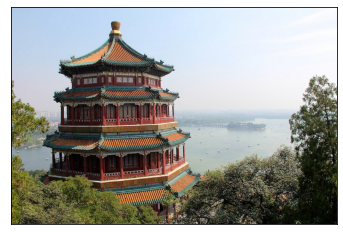

In [39]:
# step 1, load the image and show it
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

In [40]:
# step 2, print the shape of the image
print(china.shape)

(427, 640, 3)


In [41]:
# step 3, image preprocessing: rescale the pixel value to [0,1]
data = china / 255.0 # use 0...1 scale

In [42]:
# step 4, image preprocessing: reshape the data into a 2d array and keep the last dimension to 3, and print the shape
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [43]:
# step 5, Use the mini-batch k-means, 'MiniBatchKMeans()'' to reduce the number of colors into 16
from sklearn.cluster import MiniBatchKMeans
kmeans =MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

C:\Users\student\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [44]:
# step 6, Reshape the new image back to 3d array and named it as china_recolored and print the shape
china_recolored = new_colors.reshape(china.shape)
china_recolored.shape

(427, 640, 3)

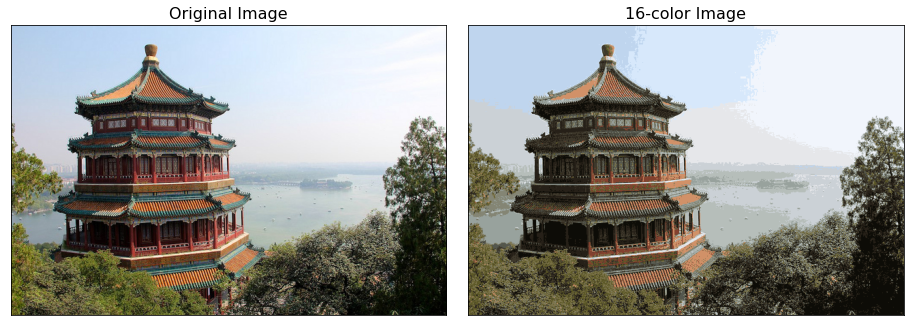

In [45]:
# step 7, Plotting the original images and the compressed image
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);